* Google Colab에서 실행시 아나콘다 없이 바로 패키지 설치해서 사용

1. 아나콘다 설치: https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html#installing-in-silent-mode

2. 설치 이후 환경 설정

conda config --add channels conda-forge

conda create -n (환경 이름) python=3.7 jupyterlab ipython matplotlib uproot numpy pandas mplhep tqdm

환경 activate: conda activate (환경 이름)

환경 deactivate : conda activate (환경 이름)

추가로 필요한 패키지는 conda install (패키지 이름)을 통해 설치

3. 환경 activate 이후 jupyter lab통해 .ipynb 파일 실행

In [1]:
#Google Colab의 경우에는 파일을 업로드해야함
#https://colab.research.google.com/github/StillWork/ds-lab/blob/master/tip_colab_%ED%8C%8C%EC%9D%BC%EC%A0%80%EC%9E%A5%EB%B0%8F%EC%97%85%EB%A1%9C%EB%93%9C_colab.ipynb 참고
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Google Colab에서 사용할시 패키지 설치
%pip install mplhep
%pip install uproot
%pip install tqdm

In [3]:
#필요한 패키지 import
import mplhep
import numpy as np
import uproot
import math
from matplotlib import pyplot as plt
from tqdm import tqdm

#그래프 스타일 설정
plt.style.use(mplhep.style.CMS)  # CMS or ATLAS/LHCb

In [21]:
#Momentum Reconstruction, Displacement Cut이 적용된 기본 알고리즘
#Displacement cut은 Plane 3/4, Plane 1/2를 통과하는 입자의 Displacement가 특정 범위 이내에만 존재하는 경우
#단위: Position[mm], Momentum[MeV], B-Field[T]
ChunkSize = 1000000

#"" 안에는 데이터 경로 지정, Google Colab의 경우에는 파일을 업로드해야함.
tup = uproot.open("/content/drive/MyDrive/KNU/Data/MC/Source/Sr_100K/run0.cfg.root:ntp1")
nEntries = tup.num_entries

momentum_DCut = []

for data in tqdm(tup.iterate(['HitNb', 'HitsensorID', 'HitposINmmX','HitposINmmY'], step_size=ChunkSize, library = 'np'), total=int(nEntries / ChunkSize) + 1):    

  for HitNb, sSID, sposX, sposY in zip(data["HitNb"], data["HitsensorID"], data["HitposINmmX"], data["HitposINmmY"]):
    #event에 4개의 hit이상이 기록된 경우
    if HitNb>=4:

      angles = []

      plane4 = []
      plane3 = []
      plane2 = []
      plane1 = []

      count4 = 0
      count3 = 0
      count2 = 0
      count1 = 0



      for SID, posX, posY in zip(sSID, sposX, sposY):
        #SensorID에 따라 각각의 좌표를 따로 Plane에 저장
          if SID==3:
              count4+=1
              plane4.append((posX, posY))
          if SID==2:
              count3+=1
              plane3.append((posX, posY))
          if SID==1:
              count2+=1
              plane2.append((posX, posY))
          if SID==0:
              count1+=1
              plane1.append((posX, posY))

      #모든 Plane에 하나의 Hit만이 존재하는 경우
      if (count4==1) and (count3==1) and (count2==1) and (count1==1):
        #[0][0]은 x좌표, [0][1]은 y 좌표에 해당. 예: (plane3[0][0]-plane4[0][0])<2은 plane3/4의 x변위가 2mm 미만이어야한다는 조건
          if ((plane3[0][0]-plane4[0][0])<2) and ((plane3[0][0]-plane4[0][0])>-2) and ((plane3[0][1]-plane4[0][1])>-1.5) and ((plane3[0][1]-plane4[0][1])<2.4) and ((plane1[0][0]-plane2[0][0])<7.5) and ((plane1[0][0]-plane2[0][0])>-7.5):
              #Plane3/4 path, Plane 1/2 path가 이루는 각도를 계산
              angles.append(np.sin(math.atan2(plane3[0][1]-plane4[0][1], -5)) - np.sin(math.atan2(plane1[0][1]-plane2[0][1], -5)))
          else:    
              pass

      #모든 Plane에 한개 이상의 Hit이 존재하는 경우
      elif count4*count3*count2*count1!=0:
          for crd4 in plane4:
              for crd3 in plane3:
                  for crd2 in plane2:
                      for crd1 in plane1:
                        #경로 조건을 맞추기 위한 조건
                          if ((crd2[0]-crd3[0])<9.5) and ((crd2[0]-crd3[0])>-10) and ((crd2[1]-crd3[1])<3) and ((crd2[1]-crd3[1])>-22):
                              if (((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25))) <= 1:
                                  theta = math.acos(((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25)))
                                  #위와 동일한 Displacement Cut
                                  if ((crd3[0]-crd4[0])<2) and ((crd3[0]-crd4[0])>-2) and ((crd3[1]-crd4[1])>-1.5) and ((crd3[1]-crd4[1])<2.4) and ((crd1[0]-crd2[0])<7.5) and ((crd1[0]-crd2[0])>-7.5):
                                      if theta > 0.3:
                                          angles.append(np.sin(math.atan2(crd3[1]-crd4[1], -5)) - np.sin(math.atan2(crd1[1]-crd2[1], -5)))
        

    #저장한 각도로부터 momentum 계산
    for angle in angles:
      momentum_DCut.append(abs(0.3*0.2*20/angle))

100%|██████████| 1/1 [01:09<00:00, 69.28s/it]


In [22]:
#Momentum Reconstruction, Radius Cut
#Radius Cut은 이상적인 입자의 궤적을 계산해 각 Plane에서 해당 궤적으로부터 일정 radius 이내에 존재하는 hit만 cut
ChunkSize = 1000000
tup = uproot.open("/content/drive/MyDrive/KNU/Data/MC/Source/Sr_100K/run0.cfg.root:ntp1")
nEntries = tup.num_entries

momentum_RCut = []

#Radius Cut의 경우에는 Momentum 참값이 필요함
origin_Z = 30
origin_Y = 0
origin_X = 0
MOM = 1.2878787878787878  #Sample's Original momentum in MeV
MAG = 0.2  #Sample's Magnitude of B-fiqld in T


for data in tqdm(tup.iterate(['HitNb', 'HitsensorID', 'HitposINmmX','HitposINmmY', 'HitmomMeVX','HitmomMeVY', 'HitmomMeVZ'], step_size=ChunkSize, library = 'np'), total=int(nEntries / ChunkSize) + 1):    
    for HitNb, sSID, sposX, sposY, smomX, smomY, smomZ in zip(data["HitNb"], data["HitsensorID"], data["HitposINmmX"], data["HitposINmmY"], data["HitmomMeVX"], data["HitmomMeVY"], data["HitmomMeVZ"]):
        
        if HitNb>=4:
            plane4 = []
            plane3 = []
            plane2 = []
            plane1 = []
            
            count4 = 0
            count3 = 0
            count2 = 0
            count1 = 0
            
            #Radius Cut에 사용될 Radius mm값
            r4 = 5
            r3 = 5
            r2 = 5
            r1 = 5
            
            angles = []
            
            for SID, posX, posY, momX, momY, momZ in zip(sSID, sposX, sposY, smomX, smomY, smomZ):
                if SID==3:
                    count4+=1
                    plane4.append((posX, posY))
                if SID==2:
                    count3+=1
                    plane3.append((posX, posY))
                if SID==1:
                    count2+=1
                    plane2.append((posX, posY))
                if SID==0:
                    count1+=1
                    plane1.append((posX, posY))
            
            if (count4==1) and (count3==1) and (count2==1) and (count1==1):
                if ((plane3[0][0]-plane4[0][0])<2) and ((plane3[0][0]-plane4[0][0])>-2) and ((plane3[0][1]-plane4[0][1])>-1.5) and ((plane3[0][1]-plane4[0][1])<2.4) and ((plane1[0][0]-plane2[0][0])<7.5) and ((plane1[0][0]-plane2[0][0])>-7.5):
                    
                    #이상적인 궤적을 계산하는 공식
                    try:
                        alpha01 = math.atan2(plane4[0][1]-origin_Y, origin_Z-20)
                        phi01 = math.atan2(plane4[0][0]-origin_X, origin_Z-20)

                        y = math.asin(math.sin(alpha01)-0.3*MAG*0.02/(0.001*MOM))
                        x3 = plane4[0][0] + 5*math.tan(phi01)
                        y3 = plane4[0][1] + 5*math.tan(alpha01)
                        x2 = x3 + (20)*math.tan(phi01)
                        y2 = y3 + (5)*math.tan(alpha01) + (10)*math.tan((alpha01+y)/2) + (5)*math.tan(y)
                        x1 = x2 + (5)*math.tan(phi01)
                        y1 = y2 + (5)*math.tan(y)
                        r4 = math.sqrt(plane4[0][0]**2 + plane4[0][1]**2)
                        r3 = math.sqrt((x3-plane3[0][0])**2 + (y3-plane3[0][1])**2)
                        r2 = math.sqrt((x2-plane2[0][0])**2 + (y2-plane2[0][1])**2)
                        r1 = math.sqrt((x1-plane1[0][0])**2 + (y1-plane1[0][1])**2)
                        
                    except:
                        pass
                    #Radius Cut 적용
                    if (r1<5) and (r2<5) and (r3<5) and (r4<5):
                        angles.append(np.sin(math.atan2(plane3[0][1]-plane4[0][1], -5)) - np.sin(math.atan2(plane1[0][1]-plane2[0][1], -5)))

                else:    
                    pass
            
            
            elif count4*count3*count2*count1!=0:
                for crd4 in plane4:
                    for crd3 in plane3:
                        for crd2 in plane2:
                            for crd1 in plane1:
                                if ((crd2[0]-crd3[0])<9.5) and ((crd2[0]-crd3[0])>-10) and ((crd2[1]-crd3[1])<3) and ((crd2[1]-crd3[1])>-22):
                                    if (((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25))) <= 1:
                                        theta = math.acos(((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25)))
                                        if theta > 0.3:
                                            
                                            try:
                                                alpha01 = math.atan2(crd4[1]-origin_Y, origin_Z-20)
                                                phi01 = math.atan2(crd4[0]-origin_X, origin_Z-20)

                                                y = math.asin(math.sin(alpha01)-0.3*MAG*0.02/(0.001*MOM))
                                                x3 = crd4[0] + 5*math.tan(phi01)
                                                y3 = crd4[1] + 5*math.tan(alpha01)
                                                x2 = x3 + (20)*math.tan(phi01)
                                                y2 = y3 + (5)*math.tan(alpha01) + (10)*math.tan((alpha01+y)/2) + (5)*math.tan(y)
                                                x1 = x2 + (5)*math.tan(phi01)
                                                y1 = y2 + (5)*math.tan(y)
                                                r4 = math.sqrt(crd4[0]**2 + crd4[1]**2)
                                                r3 = math.sqrt((x3-crd3[0])**2 + (y3-crd3[1])**2)
                                                r2 = math.sqrt((x2-crd2[0])**2 + (y2-crd2[1])**2)
                                                r1 = math.sqrt((x1-crd1[0])**2 + (y1-crd1[1])**2)

                                            except:
                                                pass
                                            
                                            if (r1<5) and (r2<5) and (r3<5) and (r4<5):
                                                angles.append(np.sin(math.atan2(crd3[1]-crd4[1], -5)) - np.sin(math.atan2(crd1[1]-crd2[1], -5)))
                                        else:
                                            pass
                                else:
                                    pass
            
            else:
                pass
                
            
        else:
            pass
        
        for angle in angles:
            momentum_RCut.append(abs(0.3*0.2*20/angle))


100%|██████████| 1/1 [01:18<00:00, 78.68s/it]


In [23]:
#Momentum Reconstruction, Radius Cut + Displacement Cut
ChunkSize = 1000000
tup = uproot.open("/content/drive/MyDrive/KNU/Data/MC/Source/Sr_100K/run0.cfg.root:ntp1")
nEntries = tup.num_entries

momentum_DRCut = []

origin_Z = 30
origin_Y = 0
origin_X = 0
MOM = 1.2878787878787878  #Sample's Original momentum
MAG = 0.2  #Sample's Magnitude of B-fiqld


for data in tqdm(tup.iterate(['HitNb', 'HitsensorID', 'HitposINmmX','HitposINmmY', 'HitmomMeVX','HitmomMeVY', 'HitmomMeVZ'], step_size=ChunkSize, library = 'np'), total=int(nEntries / ChunkSize) + 1):    
    
    for HitNb, sSID, sposX, sposY, smomX, smomY, smomZ in zip(data["HitNb"], data["HitsensorID"], data["HitposINmmX"], data["HitposINmmY"], data["HitmomMeVX"], data["HitmomMeVY"], data["HitmomMeVZ"]):
        
        if HitNb>=4:
            plane4 = []
            plane3 = []
            plane2 = []
            plane1 = []
            
            count4 = 0
            count3 = 0
            count2 = 0
            count1 = 0
            
            r4 = 5
            r3 = 5
            r2 = 5
            r1 = 5
            
            angles = []
            
            for SID, posX, posY, momX, momY, momZ in zip(sSID, sposX, sposY, smomX, smomY, smomZ):
                if SID==3:
                    count4+=1
                    plane4.append((posX, posY))
                if SID==2:
                    count3+=1
                    plane3.append((posX, posY))
                if SID==1:
                    count2+=1
                    plane2.append((posX, posY))
                if SID==0:
                    count1+=1
                    plane1.append((posX, posY))
            
            if (count4==1) and (count3==1) and (count2==1) and (count1==1):
                if ((plane3[0][0]-plane4[0][0])<2) and ((plane3[0][0]-plane4[0][0])>-2) and ((plane3[0][1]-plane4[0][1])>-1.5) and ((plane3[0][1]-plane4[0][1])<2.4) and ((plane1[0][0]-plane2[0][0])<7.5) and ((plane1[0][0]-plane2[0][0])>-7.5):
                    
                    try:
                        alpha01 = math.atan2(plane4[0][1]-origin_Y, origin_Z-20)
                        phi01 = math.atan2(plane4[0][0]-origin_X, origin_Z-20)

                        y = math.asin(math.sin(alpha01)-0.3*MAG*0.02/(0.001*MOM))
                        x3 = plane4[0][0] + 5*math.tan(phi01)
                        y3 = plane4[0][1] + 5*math.tan(alpha01)
                        x2 = x3 + (20)*math.tan(phi01)
                        y2 = y3 + (5)*math.tan(alpha01) + (10)*math.tan((alpha01+y)/2) + (5)*math.tan(y)
                        x1 = x2 + (5)*math.tan(phi01)
                        y1 = y2 + (5)*math.tan(y)
                        r4 = math.sqrt(plane4[0][0]**2 + plane4[0][1]**2)
                        r3 = math.sqrt((x3-plane3[0][0])**2 + (y3-plane3[0][1])**2)
                        r2 = math.sqrt((x2-plane2[0][0])**2 + (y2-plane2[0][1])**2)
                        r1 = math.sqrt((x1-plane1[0][0])**2 + (y1-plane1[0][1])**2)
                        
                    except:
                        pass
                    
                    if (r1<5) and (r2<5) and (r3<5) and (r4<5):
                        angles.append(np.sin(math.atan2(plane3[0][1]-plane4[0][1], -5)) - np.sin(math.atan2(plane1[0][1]-plane2[0][1], -5)))

                else:    
                    pass
            
            
            elif count4*count3*count2*count1!=0:
                for crd4 in plane4:
                    for crd3 in plane3:
                        for crd2 in plane2:
                            for crd1 in plane1:
                                if ((crd2[0]-crd3[0])<9.5) and ((crd2[0]-crd3[0])>-10) and ((crd2[1]-crd3[1])<3) and ((crd2[1]-crd3[1])>-22):
                                    if (((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25))) <= 1:
                                        theta = math.acos(((crd3[1]-crd4[1])*(crd1[1]-crd2[1])+(-5)*(-5))/(np.sqrt((crd3[1]-crd4[1])**2+25)*np.sqrt((crd1[1]-crd2[1])**2+25)))
                                        if ((crd3[0]-crd4[0])<2) and ((crd3[0]-crd4[0])>-2) and ((crd3[1]-crd4[1])>-1.5) and ((crd3[1]-crd4[1])<2.4) and ((crd1[0]-crd2[0])<7.5) and ((crd1[0]-crd2[0])>-7.5):
                                            if theta > 0.3:

                                                try:
                                                    alpha01 = math.atan2(crd4[1]-origin_Y, origin_Z-20)
                                                    phi01 = math.atan2(crd4[0]-origin_X, origin_Z-20)

                                                    y = math.asin(math.sin(alpha01)-0.3*MAG*0.02/(0.001*MOM))
                                                    x3 = crd4[0] + 5*math.tan(phi01)
                                                    y3 = crd4[1] + 5*math.tan(alpha01)
                                                    x2 = x3 + (20)*math.tan(phi01)
                                                    y2 = y3 + (5)*math.tan(alpha01) + (10)*math.tan((alpha01+y)/2) + (5)*math.tan(y)
                                                    x1 = x2 + (5)*math.tan(phi01)
                                                    y1 = y2 + (5)*math.tan(y)
                                                    r4 = math.sqrt(crd4[0]**2 + crd4[1]**2)
                                                    r3 = math.sqrt((x3-crd3[0])**2 + (y3-crd3[1])**2)
                                                    r2 = math.sqrt((x2-crd2[0])**2 + (y2-crd2[1])**2)
                                                    r1 = math.sqrt((x1-crd1[0])**2 + (y1-crd1[1])**2)

                                                except:
                                                    pass

                                                if (r1<5) and (r2<5) and (r3<5) and (r4<5):
                                                    angles.append(np.sin(math.atan2(crd3[1]-crd4[1], -5)) - np.sin(math.atan2(crd1[1]-crd2[1], -5)))
                                            else:
                                                pass
                                else:
                                    pass
            
            else:
                pass
                
            
        else:
            pass
        
        for angle in angles:
            momentum_DRCut.append(abs(0.3*0.2*20/angle))

100%|██████████| 1/1 [01:07<00:00, 67.82s/it]


In [24]:
#ntuple에 기록된 참값
#Momentum의 경우 SensorID=0을 참값으로 사용해 BTe1_df를 이용
BTe_df = tup.arrays(['HitsensorID', 'HitposINmmX','HitposINmmY', 'HitposINmmZ', 'HitmomMeVX','HitmomMeVY', 'HitmomMeVZ'], library='pd')
BTe_df.eval('HitmomMeV = sqrt(HitmomMeVX**2 + HitmomMeVY**2 + HitmomMeVZ**2)', inplace=True)
BTe1_df = BTe_df.query('HitsensorID == 0')
BTe2_df = BTe_df.query('HitsensorID == 1')
BTe3_df = BTe_df.query('HitsensorID == 2')
BTe4_df = BTe_df.query('HitsensorID == 3')

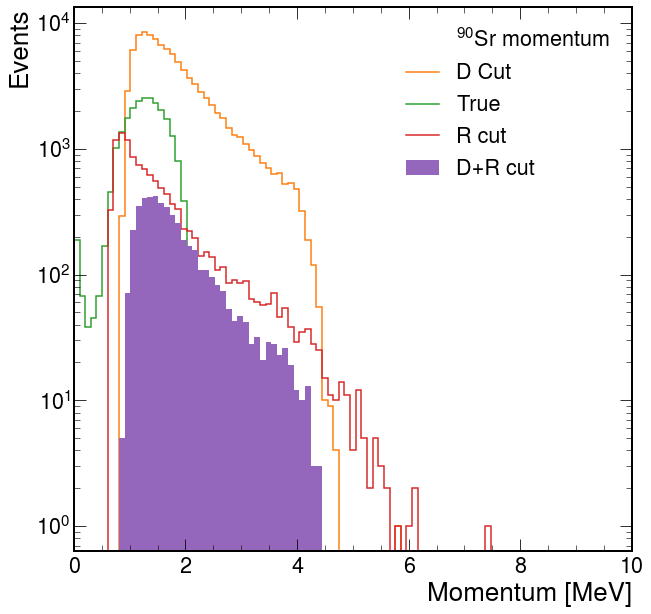

In [25]:
#이미지의 이름을 label= '(이름)'으로 사용. Latex식 수식 지원.
plt.plot([], [], ' ', label='${}^{90}Sr$ momentum')

#np.histrogram(히스토그램을 그릴 데이터, bin 사이즈)
#np.linspace(시작지점, 끝지점, n등분)
h, bins = np.histogram(momentum_DCut, bins=np.linspace(0, 10,100))

#h, bins는 고정, label은 plot의 이름
mplhep.histplot(h, bins, label='D Cut')

h, bins = np.histogram(BTe1_df['HitmomMeV'], bins=np.linspace(0, 10,100))
mplhep.histplot(h, bins, label='True')

h, bins = np.histogram(momentum_RCut, bins=np.linspace(0, 10,100))
mplhep.histplot(h, bins, label='R cut', histtype='step')

h, bins = np.histogram(momentum_DRCut, bins=np.linspace(0, 10,100))
mplhep.histplot(h, bins, label='D+R cut', histtype='fill')

#x,y축 이름 지정
plt.xlabel('Momentum [MeV]')
plt.ylabel('Events')

#y축 log scale. 비활성화는 밑줄을 지우면 됨
plt.yscale('log')

#x축 범위. y축도 동일하게 plt.ylim으로 지정가능
plt.xlim(0,10)
plt.legend()

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/home/seokju/Documents/KNU/Plots/220530/Sr_DisplacementCut.pdf')

#이미지 저장을 비활성화할시 plt.show()를 사용해야함
plt.show()